# Part B: Athena Queries

Create a database in athena using the partitioned data in S3 of the Quien es Quien en los Precios data from 2018 to 2024. 

@roman

21 apr 2024

---
# Settings

In [54]:
import os
import boto3
import awswrangler as wr
import pandas as pd
import numpy as np
import yaml
import awswrangler as wr
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get config file
with open("../../config.yaml", "r") as file:
    config = yaml.safe_load(file)

In [3]:
# AWS Settings
session = boto3.Session(profile_name=config["aws"]["profile"])
s3 = session.client("s3")

# set region east-1 to boto3
os.environ["AWS_DEFAULT_REGION"] = "us-east-1"

# Bucket
BUCKET_NAME = config["s3"]["bucket"]

# Sub Bucket
FOLDER_NAME = config["s3"]["folder"]

# Bucket Query
FILE = config["s3"]["file"]

# Database Name
DATABASE_NAME = config["athena"]["db_name"]

# Table Name
TABLE_NAME = config["athena"]["table_name"]

# Bucket Query
BUCKET_QUERY = config["athena"]["bucket_queries"]

---
# Part B Questions

## Q1: ¿De qué año a qué año tienen datos de esa categoría?

In [9]:
query = """
    SELECT 
        MIN(EXTRACT(YEAR FROM created_at)) AS min_year,
        MAX(EXTRACT(YEAR FROM created_at)) AS max_year
    FROM
        profeco_db.profeco
"""

# get df
df = wr.athena.read_sql_query(
    sql=query,
    database=DATABASE_NAME,
    ctas_approach=False,
    boto3_session=session
)
df

,min_year,max_year
0,2018,2024


Los datos, para la categoría de salud, tienen un rango de años de 2018 a 2024.

## Q2: ¿Cuántos registros de fecha hay vacíos?

In [10]:
query = """
    SELECT 
        SUM(CASE WHEN created_at IS NULL THEN 1 ELSE 0 END) AS null_dates
    FROM
        profeco_db.profeco
"""

# get df
df = wr.athena.read_sql_query(
    sql=query,
    database=DATABASE_NAME,
    ctas_approach=False,
    boto3_session=session
)
df

,null_dates
0,0


Pareciera que todos los registros tienen la fecha de creación.

## Q3: ¿Cuántos registros hay por año?

In [12]:
query = """
    SELECT 
        EXTRACT(YEAR FROM created_at) AS year,
        COUNT(1) AS count
    FROM
        profeco_db.profeco
    GROUP BY 1
    ORDER BY 1
"""

# get df
df = wr.athena.read_sql_query(
    sql=query,
    database=DATABASE_NAME,
    ctas_approach=False,
    boto3_session=session
)
df

,year,count
0,2018,3657969
1,2019,2887105
2,2020,2571915
3,2021,2937404
4,2022,3177815
5,2023,3192617
6,2024,798628


La tabla superior muestra la cantidad de registros por año en la base de datos de Profeco. Se puede observar que la cantidad de registros aumenta a lo largo de los años.

## Q4: ¿Cuál es el precio mínimo, máximo, promedio, desviación estándar, mediana, cuantil 25 y 75% de tu categoría por año?

In [20]:
query = """
    SELECT 
        EXTRACT(YEAR FROM created_at) AS year,
        AVG(price) AS avg_price,
        STDDEV(price) AS std_price,
        MIN(price) AS min_price,
        APPROX_PERCENTILE(price, 0.25) AS Q1_price,
        APPROX_PERCENTILE(price, 0.5) AS median_price,
        APPROX_PERCENTILE(price, 0.75) AS Q3_price,
        MAX(price) AS max_price
    FROM
        profeco_db.profeco
    GROUP BY 1
    ORDER BY 1
"""

# get df
df = wr.athena.read_sql_query(
    sql=query,
    database=DATABASE_NAME,
    ctas_approach=False,
    boto3_session=session
)
df

,year,avg_price,std_price,min_price,Q1_price,median_price,Q3_price,max_price
0,2018,415.927358,427.193231,5.00,91.347087,298.099020,590.956575,3535.00
1,2019,433.043714,446.192696,6.50,90.127157,313.139161,618.947086,3779.00
2,2020,419.928531,463.663499,4.50,68.006200,275.855314,617.414635,4082.00
3,2021,423.066817,488.693700,4.95,58.924315,252.645846,623.900843,4082.00
4,2022,456.027094,523.878716,6.00,61.201585,267.546577,683.941434,4104.84
5,2023,492.442195,571.924811,5.00,65.144872,284.050542,729.126371,5040.00
6,2024,505.877757,593.105319,7.01,68.156824,287.539902,745.104495,5275.00


La tabla superior muestra las estadisticas decsriptivas del precio de los medicamentos para cada año.

## Q5: ¿Cuáles son el top 5 de marcas con mayor precio en cada estado? ¿Verifica si te dió lo mismo en Spark?

In [40]:
query = """
    WITH avg_price_table AS (
        SELECT
            (CASE WHEN brand IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m' ELSE brand END) AS brand,
            state,
            AVG(price) AS avg_price
        FROM profeco_db.profeco
        GROUP BY 1, 2
    ), top5_table AS (
        SELECT
            brand,
            state,
            avg_price,
            ROW_NUMBER() OVER(PARTITION BY state ORDER BY avg_price DESC) AS row_num
        FROM avg_price_table
    )
    SELECT
        brand,
        state,
        avg_price,
        row_num
    FROM top5_table
    WHERE row_num <= 5
"""

# get df
df = wr.athena.read_sql_query(
    sql=query,
    database=DATABASE_NAME,
    ctas_approach=False,
    boto3_session=session
)

In [41]:
# pivot table by brand
df.pivot(index="state", columns="brand", values="row_num")

brand,benesta,choisemmed,citizen,duo max,ensure,home care,home care diagnostic,inhala care o home care,jumper,microlife,nebucor,omron,protec,s/m,xignal
state,,,,,,,,,,,,,,,
aguascalientes,<NA>,1,<NA>,<NA>,<NA>,<NA>,2,<NA>,<NA>,5,3,4,<NA>,<NA>,<NA>
baja california,<NA>,2,<NA>,<NA>,<NA>,<NA>,1,<NA>,5,<NA>,4,<NA>,<NA>,<NA>,3
baja california sur,<NA>,2,<NA>,<NA>,<NA>,<NA>,1,<NA>,4,<NA>,5,3,<NA>,<NA>,<NA>
campeche,<NA>,2,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>,5,3,4,<NA>,<NA>,<NA>
chiapas,<NA>,1,<NA>,<NA>,<NA>,5,3,<NA>,2,<NA>,4,<NA>,<NA>,<NA>,<NA>
chihuahua,<NA>,1,<NA>,<NA>,<NA>,4,3,<NA>,<NA>,5,2,<NA>,<NA>,<NA>,<NA>
ciudad de mexico,<NA>,1,<NA>,<NA>,<NA>,<NA>,3,<NA>,2,5,4,<NA>,<NA>,<NA>,<NA>
coahuila de zaragoza,<NA>,1,<NA>,<NA>,<NA>,<NA>,3,<NA>,5,4,2,<NA>,<NA>,<NA>,<NA>
colima,<NA>,1,5,<NA>,<NA>,2,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,4,<NA>


Nos dan las mismas tablas tanto aquí como en spark. La tabla superior muestra por columnas los productos, por renglón los estados y los valores el ranking de los productos por estado. Si contiene vacío es por que no pertenece al top 5 de ese estado.

## Q6: ¿Cuáles son el top 5 de marcas con menor precio en CDMX? (en aquel entonces Distrito Federal) ¿Verifica si te dió lo mismo en Spark?

In [42]:
query = """
    WITH avg_price_table_cdmx AS (
        SELECT
            (CASE WHEN brand IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m' ELSE brand END) AS brand,
            AVG(price) AS avg_price
        FROM profeco_db.profeco
        WHERE state = 'ciudad de mexico'
        GROUP BY 1
    ), top5_table AS (
        SELECT
            brand,
            avg_price,
            ROW_NUMBER() OVER(ORDER BY avg_price ASC) AS row_num
        FROM avg_price_table_cdmx
    )
    SELECT
        brand,
        avg_price,
        row_num
    FROM top5_table
    WHERE row_num <= 5
"""

# get df
df = wr.athena.read_sql_query(
    sql=query,
    database=DATABASE_NAME,
    ctas_approach=False,
    boto3_session=session
)
df

,brand,avg_price,row_num
0,dr. simi,14.000000,1
1,curapack,20.723846,2
2,escudo antibacterial,21.511706,3
3,zuum. klin,21.602951,4
4,hands,22.162536,5


La tabla anterior coincide con la tabla de spark

## Q7:  ¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado? ¿Verifica si te dió lo mismo en Spark?

In [39]:
query = """
    SELECT
        (CASE WHEN brand IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m' ELSE brand END) AS brand,
        COUNT(1) AS count
    FROM profeco_db.profeco
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 6
"""

# get df
df = wr.athena.read_sql_query(
    sql=query,
    database=DATABASE_NAME,
    ctas_approach=False,
    boto3_session=session
)
df

,brand,count
0,s/m,18267030
1,le roy,164858
2,zuum,105398
3,omron,80857
4,medimart,70602
5,dalux,68836


La tabla anterior coincide con la tabla de spark

## Q8: Genera un boxplot por año, para cada una de las top 5 marcas de tu categoría.

In [47]:
# Part 1: get top 5 brands
query = """
    SELECT
        (CASE WHEN brand IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m' ELSE brand END) AS brand,
        AVG(price) AS avg_price
    FROM profeco_db.profeco
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 5
"""

# get df
df = wr.athena.read_sql_query(
    sql=query,
    database=DATABASE_NAME,
    ctas_approach=False,
    boto3_session=session
)

# get names
names_top5 = df["brand"].values

# print
names_top5

<StringArray>
['choisemmed', 'home care diagnostic', 'jumper', 'nebucor', 'home care']
Length: 5, dtype: string

In [49]:
# Part 2: get top 5 brands data
query = """
    SELECT
        brand,
        EXTRACT(YEAR FROM created_at) AS year,
        price
    FROM profeco_db.profeco
    WHERE brand IN {top5}
"""
query = query.format(top5=tuple(names_top5))

# get df
df = wr.athena.read_sql_query(
    sql=query,
    database=DATABASE_NAME,
    ctas_approach=False,
    boto3_session=session
)
df

,brand,year,price
0,nebucor,2023,839.0
1,nebucor,2023,962.0
2,nebucor,2023,839.0
3,nebucor,2023,762.4
4,nebucor,2023,839.0
...,...,...,...
46893,choisemmed,2021,1059.0
46894,jumper,2021,665.0
46895,home care diagnostic,2021,965.0
46896,home care diagnostic,2021,994.0


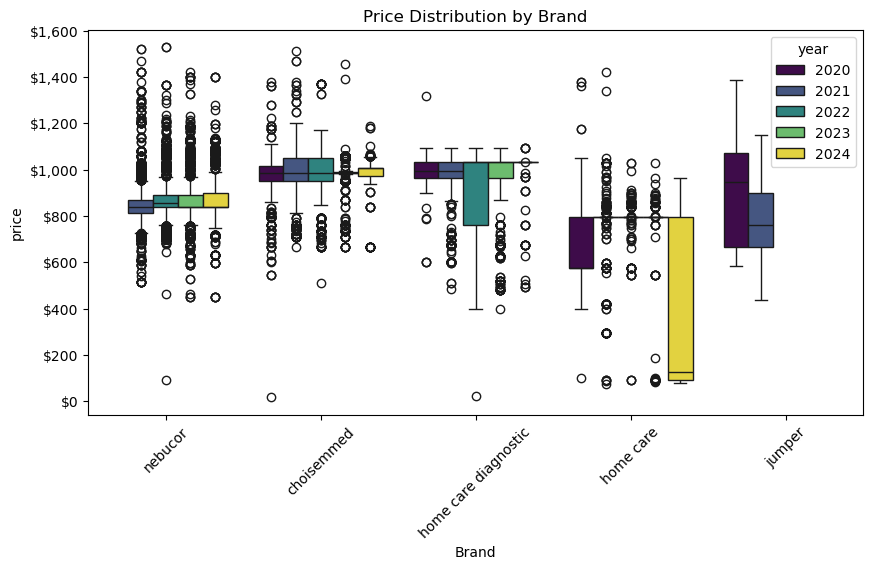

In [62]:
# Part 3: generate boxplot facet by brand
# generate boxplot facet by brand
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(
    x="brand",
    y="price",
    hue="year",
    data=df,
    ax=ax,
    palette="viridis"
)

# add title
plt.title("Price Distribution by Brand")

# add x label
plt.xlabel("Brand")

# 45 degree rotation
plt.xticks(rotation=45)

# y axis in $ format
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))

# show plot
plt.show()

Se puede observar que los precios se han mantenido relativamente constantes a lo largo de los años, aunque la marca jumper dejó de producirse a partir del 2021.